## Predict Species 


This is a multiclass classification problems (multi-nominal) of iris flowers. It is a small dataset of only 4 attributes and 150 rows. All of the attributes are numeric in the same units and the same scale which does not require any further special scaling or transformations.

Our task is to predict iris species based on different flower morphology measurements. The target (dependent) variable is called Class.

In [13]:
# Load libraries
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
from pandas import read_csv
from scipy.io import arff

from pandas.plotting import scatter_matrix
from matplotlib import pyplot 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
# Load dataset
filename = 'iris.csv'
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv(filename, names=names)

### Summarize the Dataset


Now it is time to take a look at the data. In this step we are going to take a look at the data a few different ways:

 - Dimensions of the dataset
 - Peek at the data itself
 - Statistical summary of all attributes
 - Breakdown of the data by the Class variable


#### Dimensions of Dataset

We can get a quick idea of how many instances (rows) and how many attributes (columns) the
data contains with the shape property.

In [14]:
# Dimensions of the dataset
print(dataset.shape)

(150, 5)


The dataset has 150 instances and 5 attributes.

#### Peek the Data

In [15]:
# See the first 20 rows of the dataset
print(dataset.head(20))

    sepal-length  sepal-width  petal-length  petal-width   class
0            5.1          3.5           1.4          0.2  Setosa
1            4.9          3.0           1.4          0.2  Setosa
2            4.7          3.2           1.3          0.2  Setosa
3            4.6          3.1           1.5          0.2  Setosa
4            5.0          3.6           1.4          0.2  Setosa
5            5.4          3.9           1.7          0.4  Setosa
6            4.6          3.4           1.4          0.3  Setosa
7            5.0          3.4           1.5          0.2  Setosa
8            4.4          2.9           1.4          0.2  Setosa
9            4.9          3.1           1.5          0.1  Setosa
10           5.4          3.7           1.5          0.2  Setosa
11           4.8          3.4           1.6          0.2  Setosa
12           4.8          3.0           1.4          0.1  Setosa
13           4.3          3.0           1.1          0.1  Setosa
14           5.8         

#### Statistical Summary


Now we can take a look at a summary of each attribute. This includes the count, mean, the
min and max values as well as some percentiles.

In [16]:
# Print the statistical description of each attribute in the dataset except target variable
print(dataset.describe())

       sepal-length  sepal-width  petal-length  petal-width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


#### Class Distribution


Let's now take a look at the number of instances (rows) that belong to each class. We can view this as an absolute count.

In [18]:
# Class distribution
print(dataset.groupby('class').size())

class
Setosa        50
Versicolor    50
Virginica     50
dtype: int64


We can see that each class has the same number of instances (50 or 33% of the dataset).

### Data Visualisation


We now have a basic idea about the data. We need to extend this with some visualizations. We are going to look at two types of plots:

 - Univariate plots to better understand each attribute.
 - Multivariate plots to better understand the relationships between attributes.

#### Univariate Plots


We will start with some univariate plots (plots of each individual variable). Given that
the input variables are numeric, we can create box and whisker plots of each.

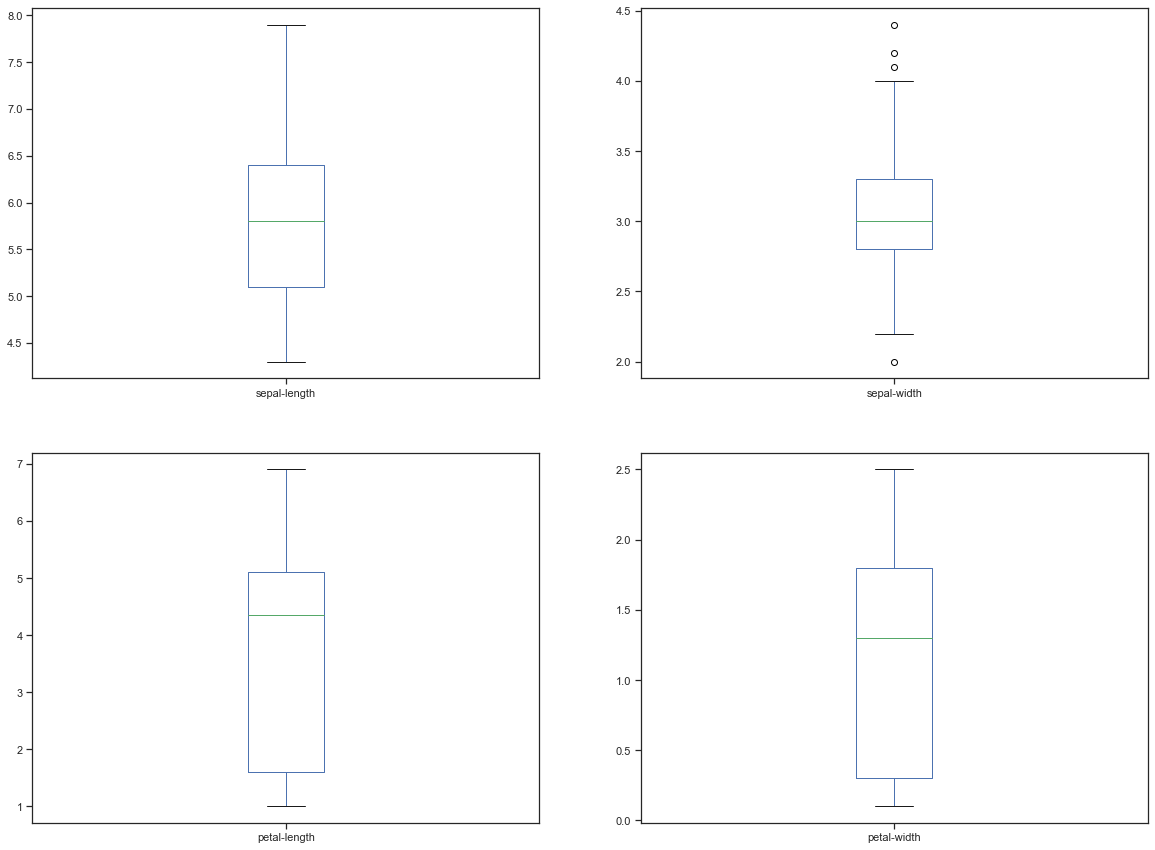

In [19]:
# Box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

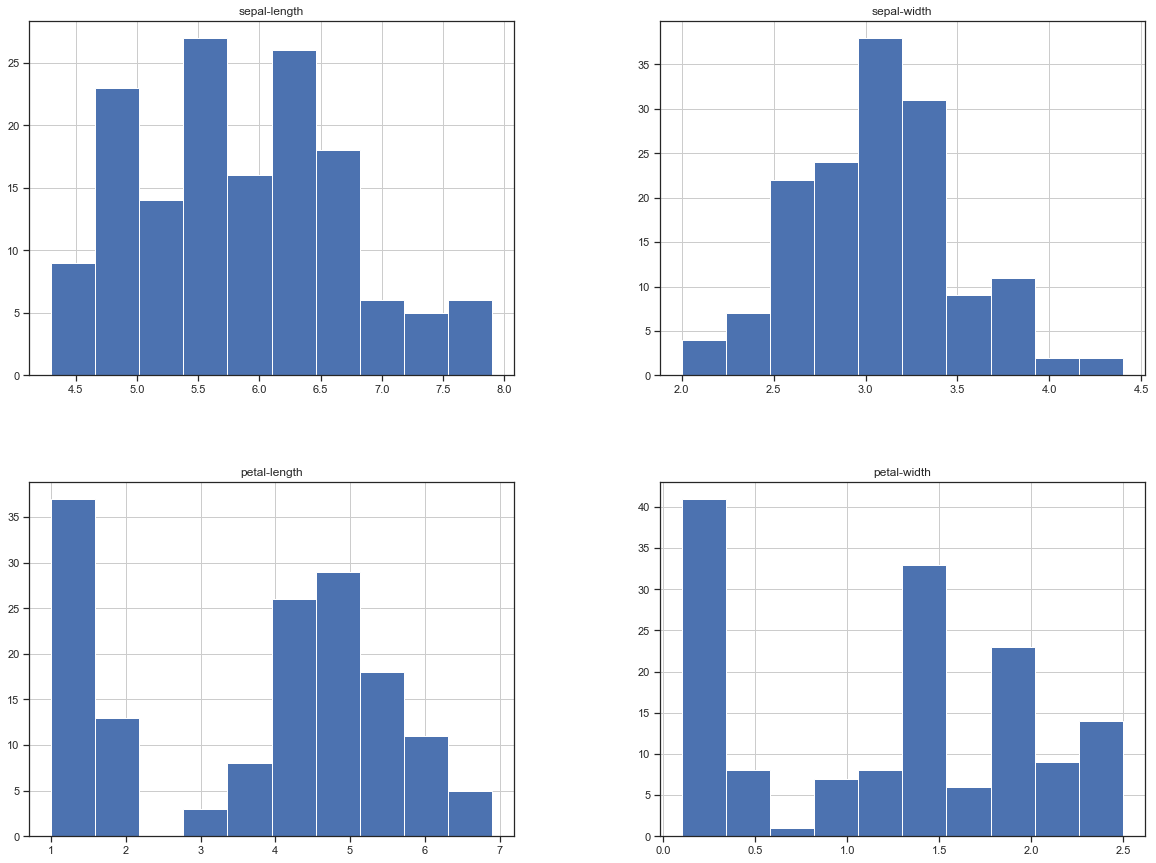

In [20]:
# Histograms
dataset.hist()
pyplot.show()

It looks like perhaps two of the input variables have a Gaussian distribution. This is useful
to note as we can use algorithms that can exploit this assumption.

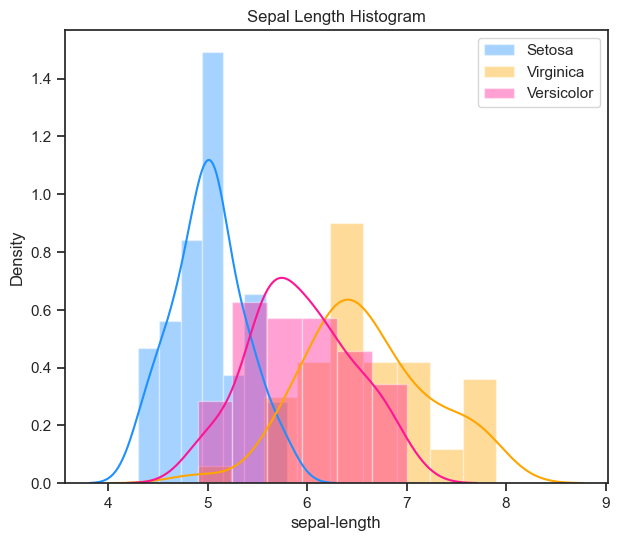

In [28]:
# Sepal length histogram coloured by target variable "class"
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot(dataset.loc[dataset["class"]=="Setosa", "sepal-length"], 
             color="dodgerblue", label="Setosa")
sns.distplot(dataset.loc[dataset["class"]=="Virginica", "sepal-length"], 
             color="orange", label="Virginica")
sns.distplot(dataset.loc[dataset["class"]=="Versicolor", "sepal-length"],
             color="deeppink", label="Versicolor")

plt.title('Sepal Length Histogram')
plt.legend();

#### Multivariate Plots


Now we can look at the interactions between the variables. Let's look at scatter plots of all pairs of attributes. This can be helpful to spot structured relationships between input variables.

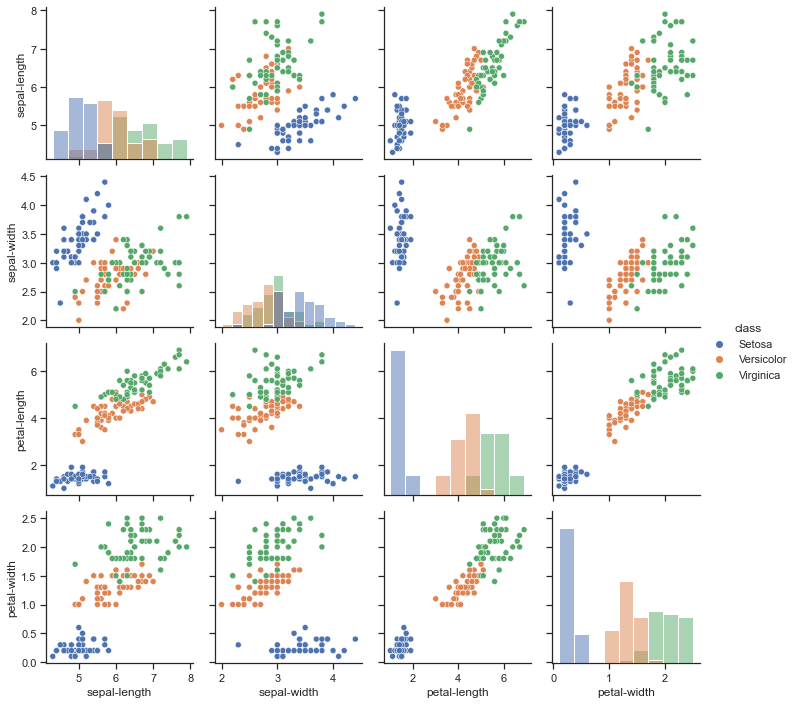

In [14]:
g = sns.PairGrid(dataset, hue="class")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Evaluate Some Algorithms


Now it is time to create some models of the data and estimate their accuracy on unseen data.

Steps that we are going to perform:

 - Separate out a validation dataset
 - Setup the test harness to use 10-fold cross validation
 - Build 5 different models to predict species from flower measurements
 - Select the best model

In [15]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

#### Test Harness
We will use 10-fold cross validation to estimate accuracy. This will split our dataset into 10 parts, train on 9 and test on 1 and repeat for all combinations of train-test splits. We are using the metric of accuracy to evaluate models. This is a ratio of the number of correctly predicted instances divided by the total number of instances in the dataset multiplied by 100 to give a percentage (e.g. 95% accurate). We will be using the scoring variable when we run build and evaluate each model next.

#### Build Models


Let's evaluate six different algorithms:
 - Logistic Regression (LR)
 - Linear Discriminant Analysis (LDA)
 - k-Nearest Neighbors (KNN).
 - Classification and Regression Trees (CART)
 - Gaussian Naive Bayes (NB)
 - Support Vector Machines (SVM)
This list is a good mixture of simple linear (LR and LDA), nonlinear (KNN, CART, NB
and SVM) algorithms. 

We reset the random number seed before each run to ensure that the
evaluation of each algorithm is performed using exactly the same data splits. It ensures the
results are directly comparable. 

In [16]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Evaluate each model in turn
results = []
names = []
num_folds = 10
seed = 7

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.983333 (0.033333)
LDA: 0.975000 (0.038188)
KNN: 0.983333 (0.033333)
CART: 0.950000 (0.076376)
NB: 0.966667 (0.040825)
SVM: 0.983333 (0.033333)


#### Select the Best Model

We can see that it looks like KNN, LR and SVM have the largest estimated accuracy score of 98,33%. We can also
create a plot of the model evaluation results and compare the spread and the mean accuracy
of each model. 

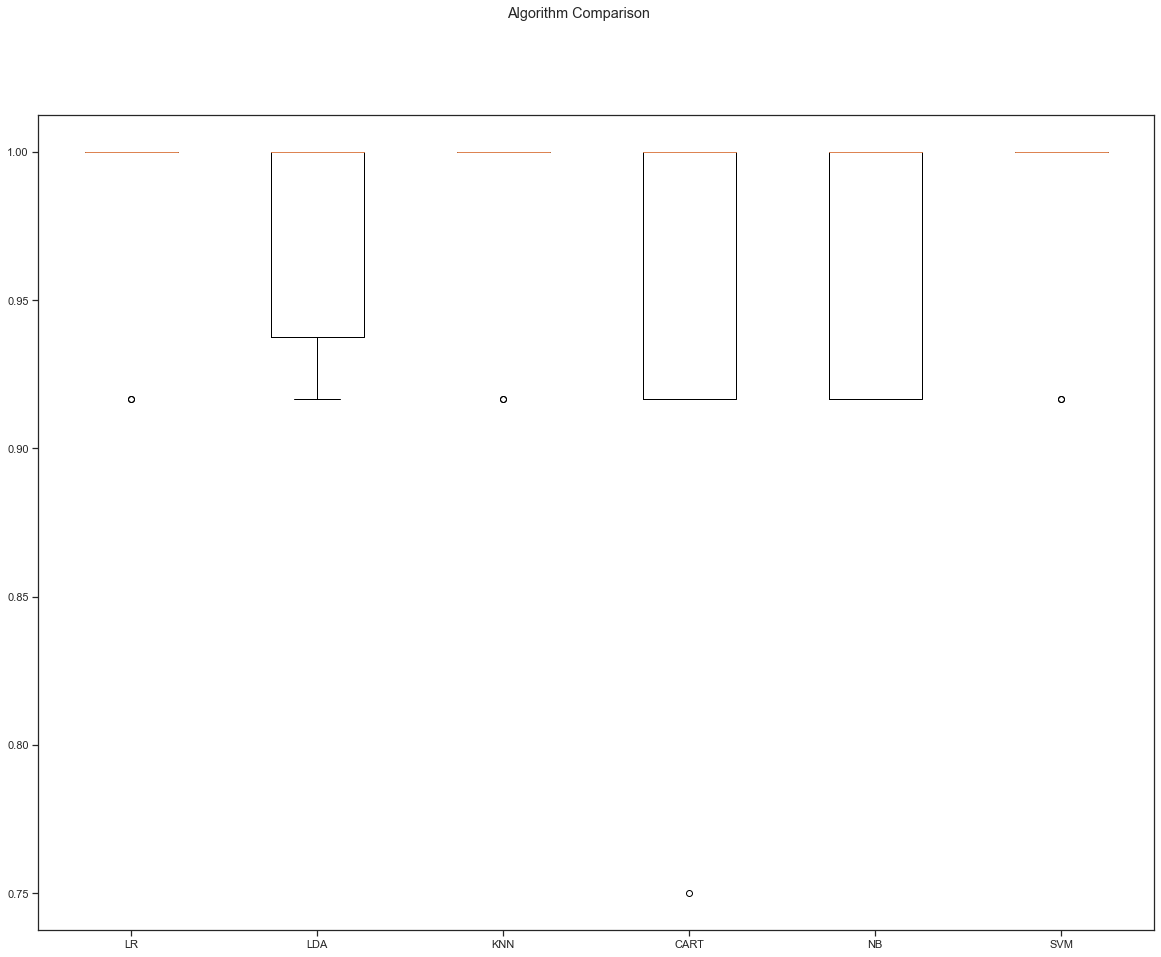

In [25]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

You can see that the box and whisker plots are squashed at the top of the range, with many
samples achieving 100% accuracy.

### Make Predictions


Now we want to get an idea of the accuracy of the model on our validation dataset. This will 
give us an independent final check on the accuracy of the best model. We can run 
the most accurate model directly on the validation set and summarize the results as a
final accuracy score, a confusion matrix and a classification report. We have three algorithms as the most accurate models. We choose KNN to make predictions on validation dataset.


Accuracy on validation dataset: 90% 

[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         7
  Versicolor       0.85      0.92      0.88        12
   Virginica       0.90      0.82      0.86        11

    accuracy                           0.90        30
   macro avg       0.92      0.91      0.91        30
weighted avg       0.90      0.90      0.90        30

Confusion Matrix in Numbers
[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]

Confusion Matrix in Percentage

[[1.   0.   0.  ]
 [0.   0.92 0.08]
 [0.   0.18 0.82]]



<AxesSubplot:>

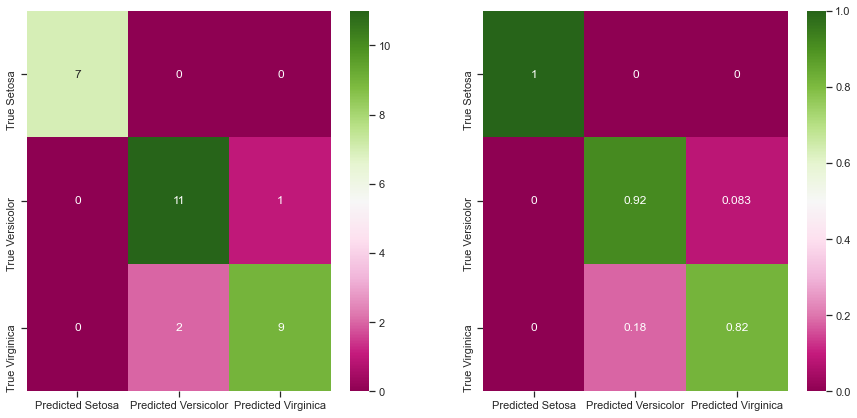

In [20]:
# Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
accuracy_knn = round(accuracy_score(Y_validation, predictions)*100, 2)
print ("Accuracy on validation dataset: %i%% \n"% accuracy_knn)
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

class_names = ['Setosa', 'Versicolor', 'Virginica']

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_validation, predictions)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('Confusion Matrix in Percentage\n')
print (cnf_matrix_percent)
print ('')


# Create dataframe of true and predicted classes for the plot
true_class_names = ['True Setosa', 'True Versicolor', 'True Virginica']
predicted_class_names = ['Predicted Setosa', 'Predicted Versicolor', 'Predicted Virginica']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

# Plot confusion matrix
plt.figure(figsize = (15,7))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d', cmap = 'PiYG')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True, cmap = 'PiYG')


We can see that the accuracy is 0.9 or 90%. Finally the classification report provides a breakdown of each class by precision, recall, f1-score and support showing excellent results (granted the validation dataset was small).